In [2]:
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
import numpy as np
import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
import pandas as pd
import pytz
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model




2023-07-08 17:18:43.108423: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:

berlin_tz = pytz.timezone('Europe/Berlin')

# TEST DATA NOT IN DATABASE YET - ETH-USD prices
dfPrices = pd.read_csv('../Abgabe/ETHUSD_1.csv')
dfPrices = dfPrices.dropna()
dfPrices.rename(columns={"1438956180": "Date", "3.0": "Open", "3.0.1": "High", "3.0.2": "Low", "3.0.3": "Close", "81.85727776": "Volume", "2": "Trades"}, inplace=True)
dfPrices['Date'] = pd.to_datetime(dfPrices['Date'], unit='s')
dfPrices['Date'] = pd.to_datetime(dfPrices['Date'], utc=True)
dfPrices['Date'] = dfPrices['Date'].dt.floor('T')
dfPrices['Date'] = dfPrices['Date'].dt.tz_convert(berlin_tz)

dfBtcPrices = pd.read_csv('../Abgabe/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')
dfBtcPrices = dfBtcPrices.dropna()
dfBtcPrices['Timestamp'] = pd.to_datetime(dfBtcPrices['Timestamp'], unit='s')
dfBtcPrices['Timestamp'] = pd.to_datetime(dfBtcPrices['Timestamp'], utc=True)
dfBtcPrices['Timestamp'] = dfBtcPrices['Timestamp'].dt.floor('T')
dfBtcPrices['Timestamp'] = dfBtcPrices['Timestamp'].dt.tz_convert(berlin_tz)
dfBtcPrices.rename(columns={"Close": "BTC_Close"}, inplace=True)
dfBtcPrices = dfBtcPrices.dropna()
dfPrices['Date'] = dfPrices['Date'].dt.strftime('%Y-%m-%d %H:%M:%S')
dfBtcPrices['Timestamp'] = dfBtcPrices['Timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')
merged_df = pd.merge(dfPrices, dfBtcPrices, left_on='Date', right_on='Timestamp')

df = merged_df
df = df.dropna()

# Adding technical indicators
df['RSI'] = ta.rsi(df.Close, length=15)
df['EMAF'] = ta.ema(df.Close, length=20)
df['EMAM'] = ta.ema(df.Close, length=100)
df['EMAS'] = ta.ema(df.Close, length=150)

df = df.dropna()
df['target'] = df['Close'].shift(-1)
print(df['target'], df['Close'])

df.dropna(inplace=True)
df.reset_index(inplace=True)

# Drop string data and 'Timestamp' column
df.drop(['Date', 'Trades', 'Volume', 'Volume_(BTC)', 'Volume_(Currency)', 'Timestamp', 'index', 'Close', 'BTC_Close', 'Weighted_Price' ], axis=1, inplace=True)





149           1.37445
150           1.23000
151           1.48500
152           1.48500
153           1.49486
              ...    
1734884    1841.69000
1734885    1841.63000
1734886    1841.69000
1734887    1842.74000
1734888           NaN
Name: target, Length: 1734740, dtype: float64 149           1.37445
150           1.37445
151           1.23000
152           1.48500
153           1.48500
              ...    
1734884    1842.04000
1734885    1841.69000
1734886    1841.63000
1734887    1841.69000
1734888    1842.74000
Name: Close, Length: 1734740, dtype: float64


In [13]:
data_set = df.iloc[:, 0:11]#.values
pd.set_option('display.max_columns', None)

data_set.head(-1)

,Open_x,High_x,Low_x,Open_y,High_y,Low_y,RSI,EMAF,EMAM,EMAS,target
0,1.37445,1.37445,1.37445,257.04,257.04,257.00,50.588359,1.300992,1.420629,1.409009,1.37445
1,1.37445,1.37445,1.37445,257.39,257.39,257.39,50.588359,1.307988,1.419714,1.408551,1.23000
2,1.23450,1.23450,1.23000,257.39,257.39,257.33,46.500526,1.300561,1.415958,1.406186,1.48500
3,1.48500,1.48500,1.48500,258.75,259.05,258.73,53.593200,1.318127,1.417325,1.407230,1.48500
4,1.48500,1.48500,1.48500,259.20,259.21,259.20,53.593200,1.334019,1.418665,1.408260,1.49486
...,...,...,...,...,...,...,...,...,...,...,...
1734733,1841.20000,1841.72000,1840.92000,58677.05,58699.90,58660.00,55.590852,1840.388572,1841.831685,1842.251702,1841.60000
1734734,1841.60000,1841.60000,1841.60000,58718.68,58731.23,58698.34,56.213463,1840.503946,1841.827097,1842.243070,1842.04000
1734735,1841.62000,1842.04000,1841.62000,58736.19,58762.43,58736.19,58.695268,1840.650237,1841.831313,1842.240381,1841.69000
1734736,1841.85000,1841.85000,1841.69000,58742.18,58742.18,58714.31,55.990560,1840.749262,1841.828515,1842.233091,1841.63000


In [14]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
data_set_scaled = sc.fit_transform(data_set)
print(data_set_scaled)

[[4.73316504e-04 4.72638490e-04 4.73414187e-04 ... 4.30438047e-04
  4.00972976e-04 4.73332782e-04]
 [4.73316504e-04 4.72638490e-04 4.73414187e-04 ... 4.29986818e-04
  4.00746815e-04 4.02365290e-04]
 [4.04562202e-04 4.03982677e-04 4.02434490e-04 ... 4.28133054e-04
  3.99578334e-04 5.27645390e-04]
 ...
 [9.04657753e-01 9.03361853e-01 9.04765835e-01 ... 9.08585183e-01
  9.09934759e-01 9.04580780e-01]
 [9.04549672e-01 9.03253927e-01 9.04736353e-01 ... 9.08583243e-01
  9.09930813e-01 9.04610258e-01]
 [9.04549672e-01 9.03283361e-01 9.04736353e-01 ... 9.08581928e-01
  9.09927311e-01 9.05126117e-01]]


In [15]:
# multiple feature from data provided to the model
X = []
#print(data_set_scaled[0].size)
#data_set_scaled=data_set.values
backcandles = 30
print(data_set_scaled.shape[0])
for j in range(10):#data_set_scaled[0].size):#2 columns are target not X
    X.append([])
    for i in range(backcandles, data_set_scaled.shape[0]):#backcandles+2
        X[j].append(data_set_scaled[i-backcandles:i, j])

#move axis from 0 to position 2
X=np.moveaxis(X, [0], [2])

#Erase first elements of y because of backcandles to match X length
#del(yi[0:backcandles])
#X, yi = np.array(X), np.array(yi)
# Choose -1 for last column, classification else -2...
X, yi =np.array(X), np.array(data_set_scaled[backcandles:,-1])
y=np.reshape(yi,(len(yi),1))
#y=sc.fit_transform(yi)
#X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X)
print(X.shape)
print(y)
print(y.shape)

1734739
[[[4.73316504e-04 4.72638490e-04 4.73414187e-04 ... 4.17948903e-04
   4.30438047e-04 4.00972976e-04]
  [4.73316504e-04 4.72638490e-04 4.73414187e-04 ... 4.21393395e-04
   4.29986818e-04 4.00746815e-04]
  [4.04562202e-04 4.03982677e-04 4.02434490e-04 ... 4.17736452e-04
   4.28133054e-04 3.99578334e-04]
  ...
  [3.63049244e-04 3.62529185e-04 3.63124170e-04 ... 4.29949535e-04
   4.18248997e-04 3.94240193e-04]
  [4.07755507e-04 4.07171407e-04 4.07839659e-04 ... 4.25993522e-04
   4.16735149e-04 3.93229879e-04]
  [3.87613125e-04 3.87057878e-04 3.87693120e-04 ... 4.20491746e-04
   4.14850653e-04 3.91964632e-04]]

 [[4.73316504e-04 4.72638490e-04 4.73414187e-04 ... 4.21393395e-04
   4.29986818e-04 4.00746815e-04]
  [4.04562202e-04 4.03982677e-04 4.02434490e-04 ... 4.17736452e-04
   4.28133054e-04 3.99578334e-04]
  [5.27627245e-04 5.26871432e-04 5.27736136e-04 ... 4.26384965e-04
   4.28807690e-04 4.00094112e-04]
  ...
  [4.07755507e-04 4.07171407e-04 4.07839659e-04 ... 4.25993522e-04
  

In [16]:
# split data into train test sets
splitlimit = int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)

1387767
(1387767, 30, 10)
(346942, 30, 10)
(1387767, 1)
(346942, 1)
[[0.00038763]
 [0.00038763]
 [0.00046703]
 ...
 [0.11425495]
 [0.11428443]
 [0.11427952]]


In [17]:

#tf.random.set_seed(20)
np.random.seed(10)

lstm_input = Input(shape=(backcandles, 10), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=y_train, batch_size=70, epochs=1, shuffle=True, validation_split = 0.1)

2023-07-08 18:07:41.417348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-08 18:07:41.422202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-08 18:07:41.424856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

ValueError: in user code:

    File "/Users/parvezmalik/Library/Python/3.9/lib/python/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/Users/parvezmalik/Library/Python/3.9/lib/python/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/parvezmalik/Library/Python/3.9/lib/python/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/Users/parvezmalik/Library/Python/3.9/lib/python/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/Users/parvezmalik/Library/Python/3.9/lib/python/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/parvezmalik/Library/Python/3.9/lib/python/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_2" is incompatible with the layer: expected shape=(None, 30, 8), found shape=(None, 30, 10)


In [10]:
y_pred = model.predict(X_test)
#y_pred=np.where(y_pred > 0.43, 1,0)
for i in range(10):
    print(y_pred[i], y_test[i])

2023-07-08 18:00:09.789656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-08 18:00:09.793111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-08 18:00:09.797300: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10842/10842 [==============================] - 184s 17ms/step
[0.11420152] [0.11422548]
[0.11424423] [0.11423039]
[0.11420432] [0.11424513]
[0.11420368] [0.11428443]
[0.11419808] [0.11428443]
[0.11421192] [0.11446621]
[0.11424284] [0.11443673]
[0.11431605] [0.11451043]
[0.11438911] [0.11451534]
[0.1144543] [0.11458412]


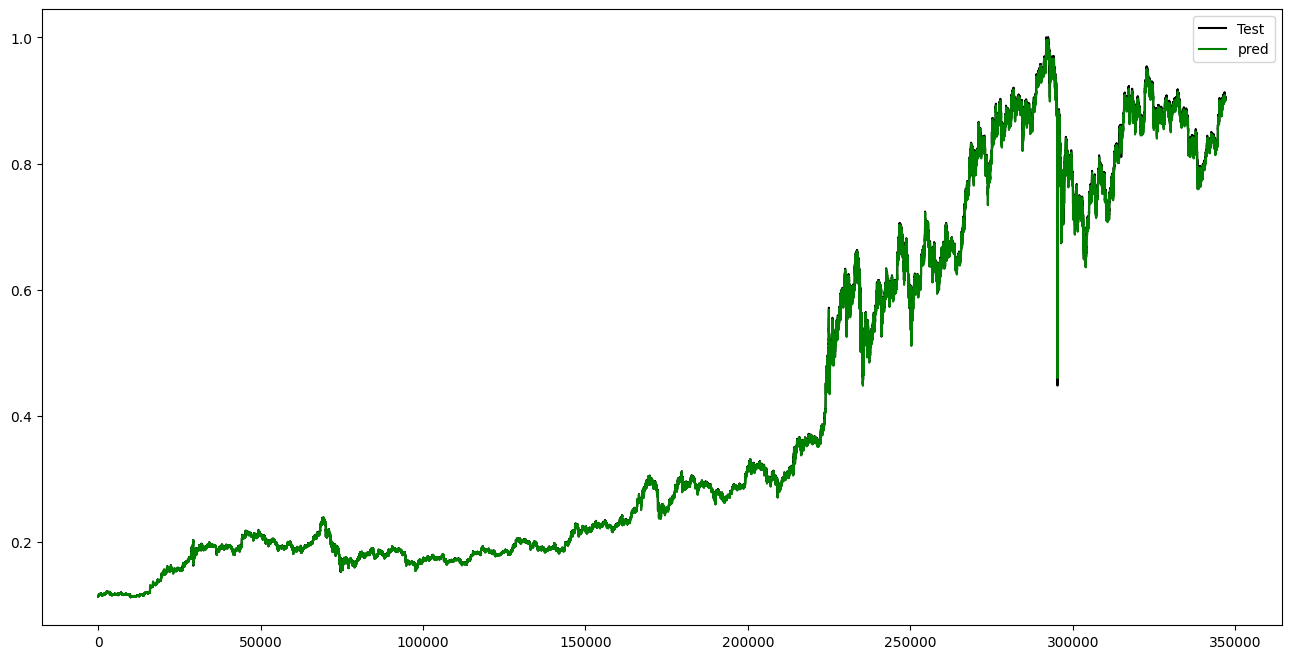

In [11]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(y_pred, color = 'red', label = 'pred')
plt.legend()
plt.show()